# Identify redshift and emission lines in WL spectra using CCF

This code has been developed to find single emission lines (e.g. OII and Lya) in WL spectra and uses a cross-correlation function approach. It will identify emission lines at all redshift and determine the redshift from their wavelength ratios. 

In this example notebook, I show how you can run the algorithm on either your own input OB from WEAVE or a query from WEAVEIO.

Just a little warning for any user: 

The current version is still work in progress and takes quite a long time to run (about 1 min/spectrum). Printing and saving files will slow it down. Please let me know if you find any errors or if you would like me to add a certain feature. 

## Import functions and packages

In [1]:
import temp_fitting as temp_fit
import spec_func as spec
import open_data as read_data
import emission_lines as line
import plotting as plot
import ccf_func as ccf
import injecting_lines as inject

import numpy as np
from astropy.io import fits
import warnings
import time
from astropy.table import Table

# Ignore warnings unless debugging
import warnings
warnings.simplefilter("ignore")

# # For debugging
# %load_ext autoreload
# %autoreload 2

## Input your own spectra files

Comment out if you would like to use WEAVEIO to input your data!

In [17]:
run_name = 'ccf_example_test' # Set a name for saving the files

# File paths for blue and red OB or spectrum
red_spectra = '/home/gloudemans/weave_test_data/OB/3130/stacked/stacked_1002813.fit'
blue_spectra = '/home/gloudemans/weave_test_data/OB/3130/stacked/stacked_1002814.fit'

# Read data and convert to specutils Spectrum1D object 
spec_info_red  = read_data.readin_spectra(red_spectra)
spec_info_blue = read_data.readin_spectra(blue_spectra)

target_bool = (spec_info_blue['table']['TARGUSE'] == 'T') # Identify targets
sky_line_bool = (spec_info_blue['table']['TARGUSE'] == 'S') # Identify sky fibers 

# IMPORTANT STEP: Pick specific spectra from OB
# If comment this out then you will run through the full OB (which takes a long time)
target_bool = read_data.pick_spectrum(target_bool, 6, 3) # In this example pick 3 target spectra starting at number 6
sky_line_bool = read_data.pick_spectrum(sky_line_bool, 2, 1) # In this example pick 10 skyline spectra starting at number 60

# Input catalog with target information and input redshifts (only for simulated data)
# Set to False if not available
input_catalog = Table.read('/beegfs/lofar/duncan/WEAVE/OpR3b/MockData/merged_cat_mags_all_OpR3.fits') 
input_redshifts = read_data.input_redshifts_match_weaveio(spec_info_red['table'][target_bool], input_catalog) 

target_names = spec_info_blue['table']['TARGNAME'][target_bool]

## Input WEAVEIO spectra

Comment out if you are using your own spectra files!

In [16]:
# DOES NOT WORK FOR NOW #

# run_name = 'ccf_example_test' # Set a name for saving the files

# from weaveio import *

# data = Data(rootdir='/beegfs/weavelofar/weaveio')
# obs = data.obs

# l2s = data.l2stacks
# stacks_blue = obs.l1stack_spectra[(obs.l1stack_spectra.targuse == 'T') & (obs.l1stack_spectra.camera == 'blue') & any(obs.l1stack_spectra.fibre_target.surveys == '/WL.*/', wrt=obs.l1stack_spectra.fibre_target)] #& obs.l1stack_spectra.surveys == '/WL.*/']#& (obs.ob.id == 3191)] 
# stacks_red = obs.l1stack_spectra[(obs.l1stack_spectra.targuse == 'T') & (obs.l1stack_spectra.camera == 'red')& any(obs.l1stack_spectra.fibre_target.surveys == '/WL.*/', wrt=obs.l1stack_spectra.fibre_target)]  #& obs.l1stack_spectra.surveys == '/WL.*/']#& (obs.ob.id == 3191)] 

# # WEAVE-IO ERROR HERE 
# table_blue = stacks_blue[['wvl', 'flux', 'ivar', 'sensfunc', 'targid', 'targname']]()
# table_red = stacks_red[['wvl', 'flux', 'ivar', 'sensfunc', 'targid', 'targname']]()

# table_blue_sorted, table_red_sorted = read_data.match_blue_red_spectra(table_blue, table_red) # Sort red and blue spectra 

# # Read data and convert to specutils Spectrum1D object 
# spec_info_red  = read_data.readin_spectra(table_red_sorted)
# spec_info_blue = read_data.readin_spectra(table_blue_sorted)


# # Pick specific spectra:
# target_bool = read_data.pick_spectrum_weaveio(spec_info_blue, 7, 3) # In this example pick 3 target spectra starting at number 6

# # Input redshifts available?
# # Set to False if not available
# input_catalog = Table.read('/beegfs/lofar/duncan/WEAVE/OpR3b/MockData/merged_cat_mags_all_OpR3.fits')
# input_redshifts = read_data.input_redshifts_match_weaveio(table_red_sorted, input_catalog)

# target_names = table_blue['targname'][target_bool]


## Optional: Define mask regions

Input 1 or more wavelengths regions where you want to mask the spectrum (e.g. because of cosmic ray)

In [3]:
# Example: np.array([[wav_start1, wav_stop1], [wav_start2, wav_stop2], etc])

mask_blue = np.array([[np.nan, np.nan]])
mask_red = np.array([[np.nan, np.nan]])

## Run CCF on spectra

In this example the CCF and emission line algorithm is run on the input data. You can run it both on an OB or a single spectrum.

The function determines the redshift and emission lines for each input spectrum. It outputs the redshifts, emission line wavelengths, fluxes and SNRs of each spectrum. 

Running CCF for 3 targets...
Target OPR3_267819797
Input redshift =  0.485409
CCF redshift solutions.. [0.486, 0.996, 5.117, 5.12]
Lines detected before final =  [5745.680466089574, 6462.67322427397, 7229.007920073811, 7365.613934948262, 7438.188028006155, 8722.941468892126]
Ratio redshift 0.48580934532695536
Lines detected =  [5745.68046609 6462.67322427 7229.00792007 7365.61393495 7438.18802801
 8722.94146889]


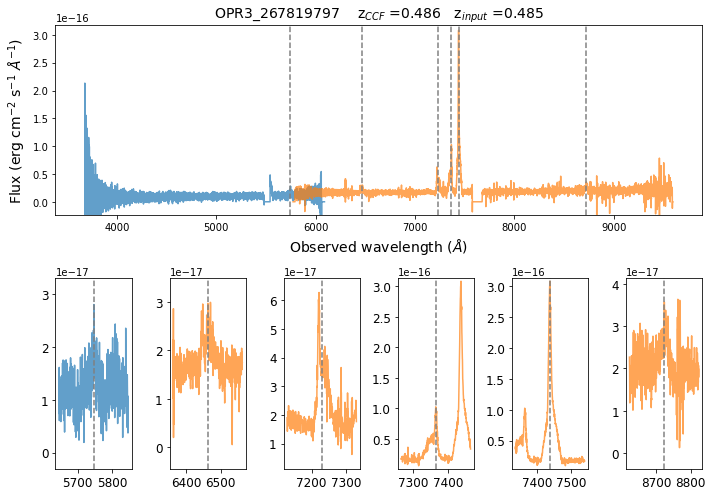

Target OPR3_37858056
Input redshift =  1.033869981765747
CCF redshift solutions.. [0.879, 6.862]
Lines detected before final =  []
Ratio redshift nan
Lines detected =  []


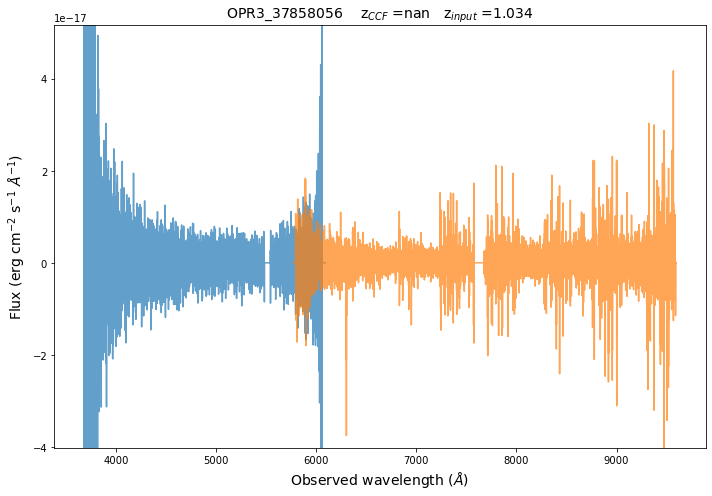

Target OPR3_67576410
Input redshift =  0.632849
CCF redshift solutions.. [0.634, 0.633, 1.195, 5.725, 5.73]
Lines detected before final =  [6087.296032554555, 7949.688894796786, 8086.137211169829, 8179.474477634155]
Ratio redshift 0.6324464873699928
Lines detected =  [6087.29603255 7949.6888948  8086.13721117 8179.47447763]


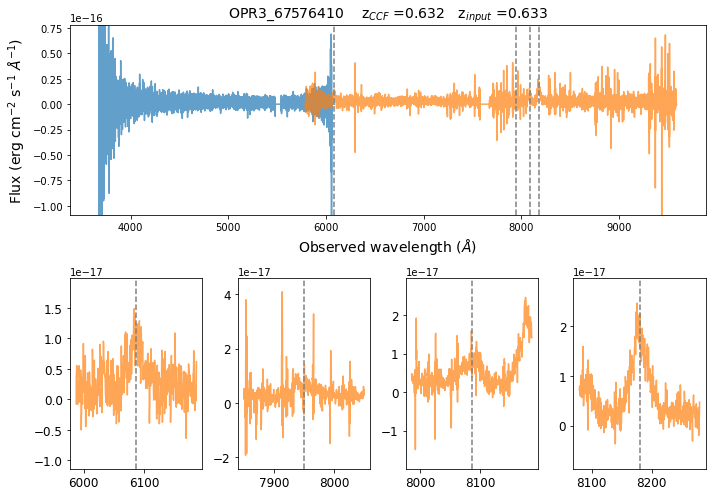

Number single line targets found =  0
Done!


In [4]:
# Adjust these input variables accordingly:

input_z = input_redshifts # Set to False if do not have any input redshifts
save_plot = False # Set to True if you want to save the plots created
write_table = False # Set to True if you want to save the table with the redshift and emission line output
print_output = True # Set to True if you want to print the different steps of the algorithm
diagnostic_output = False # Set to True if you want to save diagnostic plots (not recommended)
show_result = True # Set to True if you want to show resulting spectrum here 
fix_redshift = False # Set to True if you want to fix the redshift to the input redshift and skip the CCF step - determine only emission lines

# Comment out if you have defined masked wavelength regions 
mask_blue = False
mask_red = False

# Run the CCF and output the redshifts and emission line info
redshifts_template_fitting, emission_line_wavelengths, emission_line_fluxes, emission_line_snrs = temp_fit.template_fitting(spec_info_blue['spectra'][target_bool], spec_info_red['spectra'][target_bool], spec_info_blue['table'][target_bool], spec_info_red['table'][target_bool], target_names, run_name,  mask_blue, mask_red, input_z, save_plot, write_table, print_output, diagnostic_output, show_result, fix_redshift, False)



In [5]:
# Check for example the wavelengths of the emission lines found:
print(emission_line_wavelengths) 

[array([5745.68046609, 6462.67322427, 7229.00792007, 7365.61393495,
       7438.18802801, 8722.94146889]), array([], dtype=float64), array([6087.29603255, 7949.6888948 , 8086.13721117, 8179.47447763])]


## Inject single emission line in sky spectrum

To investigate the flux limit at which we can detect single emission lines, here you can inject a single line in 1 or more sky spectra. You can specify the redshift, luminosity and width of the line or input an array for either redshift or luminosities and widths.

The sky spectrum with injected line will be run through the CCF algorithm to determine whether it can be retrieved.

Running CCF for 1 targets...


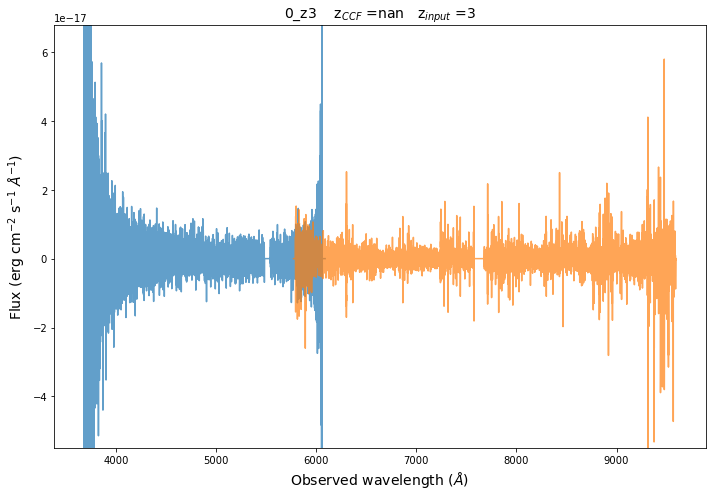

Number single line targets found =  0
Done!
Running CCF for 1 targets...


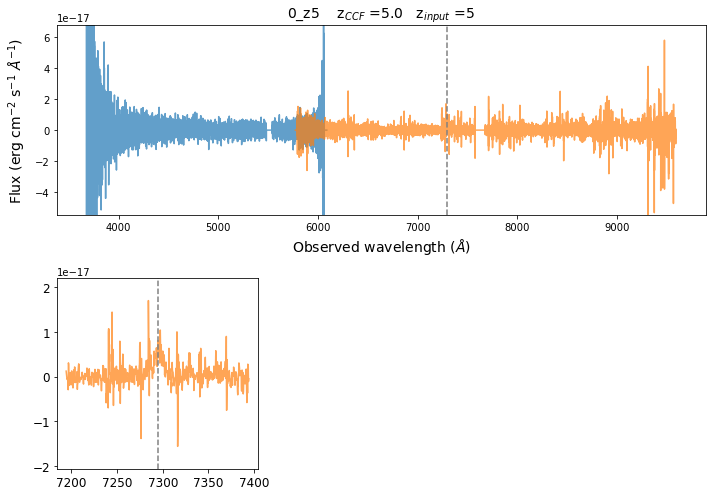

Number single line targets found =  1
Done!


In [18]:
# Comment out if you have defined masked wavelength regions 
mask_blue = False
mask_red = False

save_plot = False # Set to True if you want to save the plots created
write_table = False # Set to True if you want to save the table with the redshift and emission line output
print_output = False # Set to True if you want to print the different steps of the algorithm
diagnostic_bool = False # Set to True if you want to save diagnostic plots (not recommended)
show_result = True # Set to True if you want to show resulting spectrum here


# Example injecting a single emission line at different redshifts

lum_line = 10**43.0 # Luminosity of the line in erg/s
std_line = 5.0 # Standard deviation of gaussian in Angstrom
z_line = [3, 5] 
rest_wav_line = 1216. # wavelength Lya in Angstrom
line_type = 'gaussian'

fraction_detected_lines, spurious_detected_lines, redshift_fraction_correct = inject.inject_gaussian_lines(rest_wav_line, line_type, z_line, lum_line, std_line, spec_info_blue['spectra'][sky_line_bool], spec_info_red['spectra'][sky_line_bool], spec_info_blue['table'][sky_line_bool], spec_info_red['table'][sky_line_bool], np.array([str(i) for i in range(np.sum(sky_line_bool))]), run_name,  mask_blue, mask_red, save_plot, write_table, print_output, diagnostic_bool, show_result)




Running CCF for 1 targets...


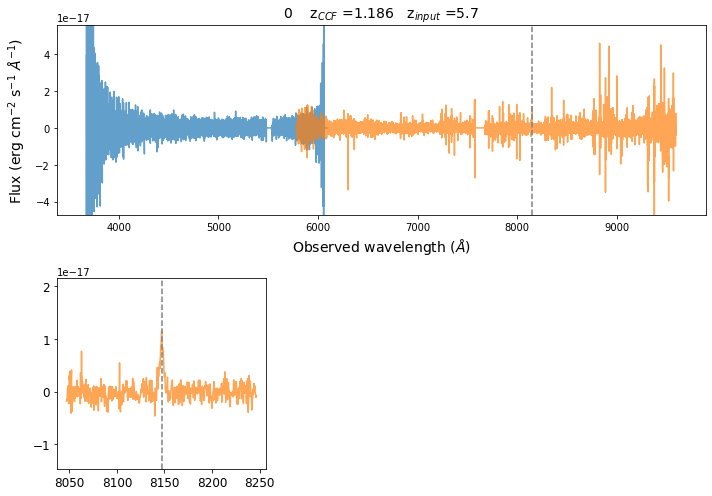

Number single line targets found =  1
Done!
Running CCF for 1 targets...


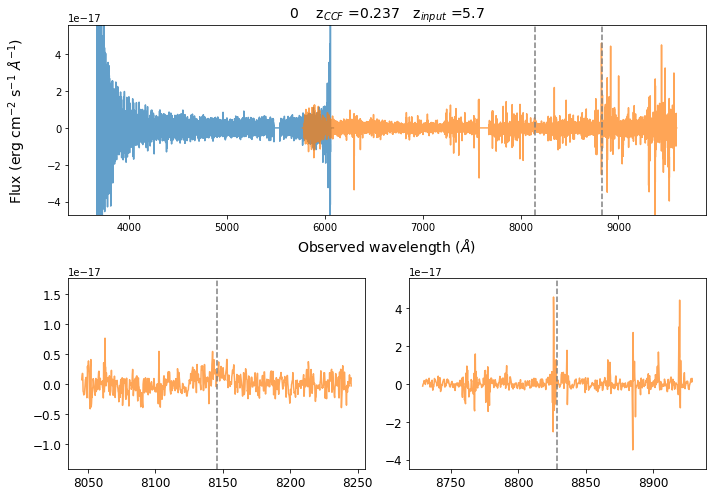

Number single line targets found =  0
Done!
Running CCF for 1 targets...


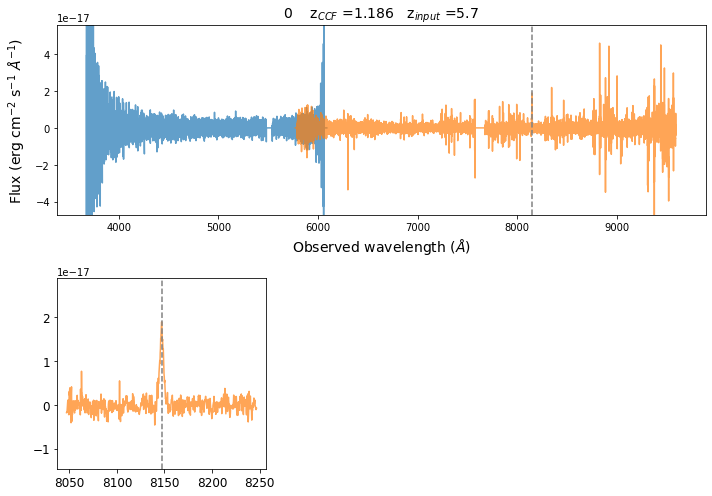

Number single line targets found =  1
Done!
Running CCF for 1 targets...


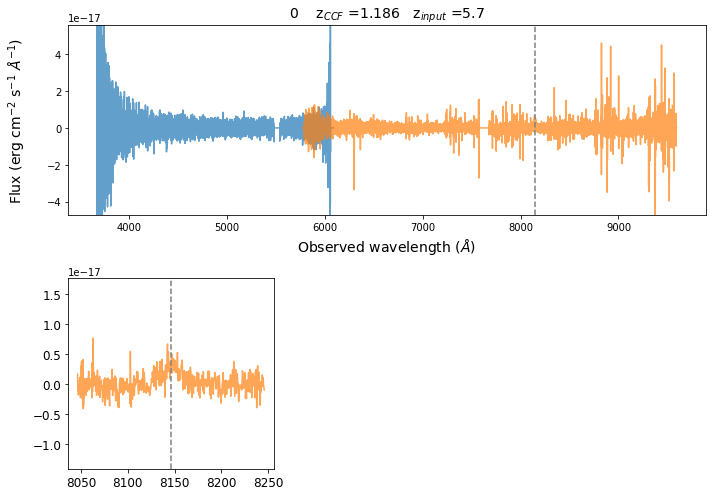

Number single line targets found =  1
Done!


In [20]:
# Comment out if you have defined masked wavelength regions 
mask_blue = False
mask_red = False

save_plot = False # Set to True if you want to save the plots created
write_table = False # Set to True if you want to save the table with the redshift and emission line output
print_output = False # Set to True if you want to print the different steps of the algorithm
diagnostic_bool = False # Set to True if you want to save diagnostic plots (not recommended)
show_result = True # Set to True if you want to show resulting spectrum here


# Example injecting a single emission line with different luminosities and widths
lum_line = np.array([10**43.25, 10**43.5]) # Luminosity of the line in erg/s
std_line = np.array([2, 11]) # Standard deviation of gaussian in Angstrom
z_line = 5.7
rest_wav_line = 1216. # wavelength Lya in Angstrom
line_type = 'gaussian' 

fraction_detected_lines, spurious_detected_lines, redshift_fraction_correct = inject.inject_gaussian_lines(rest_wav_line, line_type, z_line, lum_line, std_line, spec_array_blue[sky_line_bool], spec_array_red[sky_line_bool], table_blue[sky_line_bool], table_red[sky_line_bool], np.array([str(i) for i in range(np.sum(sky_line_bool))]), run_name,  mask_blue, mask_red, save_plot, write_table, print_output, diagnostic_bool, show_result)
